# Morphing Attack Detection

In [3]:
# Check environment
import sys
print(f"Python version: {sys.version}")

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from pathlib import Path
from tqdm import tqdm
import time

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Create directories
os.makedirs('morph_data/genuine', exist_ok=True)
os.makedirs('morph_data/morphed', exist_ok=True)
os.makedirs('morph_results', exist_ok=True)

print("\n✓ Environment ready!")

Python version: 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.88 GB

✓ Environment ready!


# Download Face Dataset (labelled faces in the wild)

In [11]:
from sklearn.datasets import fetch_lfw_people

print("Downloading LFW dataset via scikit-learn...")
print("Direct download failed due to firewall issues.")
print("="*80)

# Download LFW dataset (scikit-learn handles everything)
lfw_people = fetch_lfw_people(
    min_faces_per_person=1,  # Include all people
    resize=1.0,  # Keep original size
    color=True,  # Color images
    download_if_missing=True
)

print(f"\n✓ Downloaded {len(lfw_people.images)} face images")
print(f"✓ Image shape: {lfw_people.images[0].shape}")
print(f"✓ Number of people: {len(lfw_people.target_names)}")

# Convert to list of image arrays for easier processing
all_images = lfw_people.images
print(f"✓ Ready for morph generation")

# Select subset (500 images for speed)
np.random.seed(42)
n_samples = min(500, len(all_images))
selected_indices = np.random.choice(len(all_images), size=n_samples, replace=False)
selected_images = [all_images[i] for i in selected_indices]

print(f"\n✓ Selected {len(selected_images)} images for processing")
print(f"✓ Dataset ready!")

This is more reliable than direct download.

✓ Downloaded 13233 face images
✓ Image shape: (125, 94, 3)
✓ Number of people: 5749
✓ Ready for morph generation

✓ Selected 500 images for processing
✓ Dataset ready!


# Face Detection and Alignment Helper Functions

In [12]:
import cv2

def align_faces(img1, img2):
    """
    Ensure two images are the same size for morphing.
    LFW images from scikit-learn should already be aligned, but this ensures it.
    """
    # Convert to uint8 if needed
    if img1.dtype == np.float64 or img1.dtype == np.float32:
        img1 = (img1 * 255).astype(np.uint8)
    if img2.dtype == np.float64 or img2.dtype == np.float32:
        img2 = (img2 * 255).astype(np.uint8)
    
    # Ensure same size
    h, w = img1.shape[:2]
    img2_resized = cv2.resize(img2, (w, h))
    
    return img1, img2_resized

def create_morph(img1, img2, alpha=0.5):
    """
    Create a morphed image by blending two faces.
    
    Args:
        img1, img2: Input face images (numpy arrays)
        alpha: Blending weight (0.5 = equal blend, 0.3 = 30% img1 + 70% img2)
    
    Returns:
        Morphed image
    """
    # Align faces
    img1_aligned, img2_aligned = align_faces(img1, img2)
    
    # Blend images
    morphed = cv2.addWeighted(img1_aligned, alpha, img2_aligned, 1-alpha, 0)
    
    return morphed

def save_image(img, path):
    """Save image to disk"""
    if img.dtype == np.float64 or img.dtype == np.float32:
        img = (img * 255).astype(np.uint8)
    
    # Convert RGB to BGR for OpenCV
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = img
    
    cv2.imwrite(str(path), img_bgr)

print("✓ Morphing functions ready")

✓ Morphing functions ready


# Generate Morphed Dataset

In [14]:
print("Generating morphed images...")
print("="*80)

# Parameters
n_morphs = 250  # Generate 250 morphed images
n_genuine = 250  # Keep 250 genuine images (for balanced dataset)

# Create morph pairs
np.random.seed(42)
morph_count = 0
genuine_count = 0

print(f"Target: {n_morphs} morphed + {n_genuine} genuine = {n_morphs + n_genuine} total")
print()

# Generate morphs
print("Creating morphed images...")
for i in tqdm(range(n_morphs)):
    # Select two random different faces
    idx1, idx2 = np.random.choice(len(selected_images), size=2, replace=False)
    img1 = selected_images[idx1]
    img2 = selected_images[idx2]
    
    # Create morph with alpha=0.5 (equal blend)
    try:
        morphed = create_morph(img1, img2, alpha=0.5)
        
        # Save morphed image
        save_path = Path(f'morph_data/morphed/morph_{i:04d}.jpg')
        save_image(morphed, save_path)
        morph_count += 1
    except Exception as e:
        print(f"\n⚠ Error creating morph {i}: {e}")
        continue

print(f"\n✓ Created {morph_count} morphed images")

# Copy genuine images
print("\nCopying genuine images...")
for i in tqdm(range(n_genuine)):
    idx = np.random.choice(len(selected_images))
    img = selected_images[idx]
    
    try:
        save_path = Path(f'morph_data/genuine/genuine_{i:04d}.jpg')
        save_image(img, save_path)
        genuine_count += 1
    except Exception as e:
        print(f"\n⚠ Error saving genuine {i}: {e}")
        continue

print(f"\n✓ Saved {genuine_count} genuine images")

# Summary
print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80)
print(f"Morphed images: {morph_count}")
print(f"Genuine images: {genuine_count}")
print(f"Total images: {morph_count + genuine_count}")
print(f"Class balance: {genuine_count/(morph_count + genuine_count)*100:.1f}% genuine, {morph_count/(morph_count + genuine_count)*100:.1f}% morphed")

Generating morphed images...
Target: 250 morphed + 250 genuine = 500 total

Creating morphed images...


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 2029.27it/s]



✓ Created 250 morphed images

Copying genuine images...


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 2116.74it/s]


✓ Saved 250 genuine images

DATASET SUMMARY
Morphed images: 250
Genuine images: 250
Total images: 500
Class balance: 50.0% genuine, 50.0% morphed


# Visualize Examples

Loading example images...


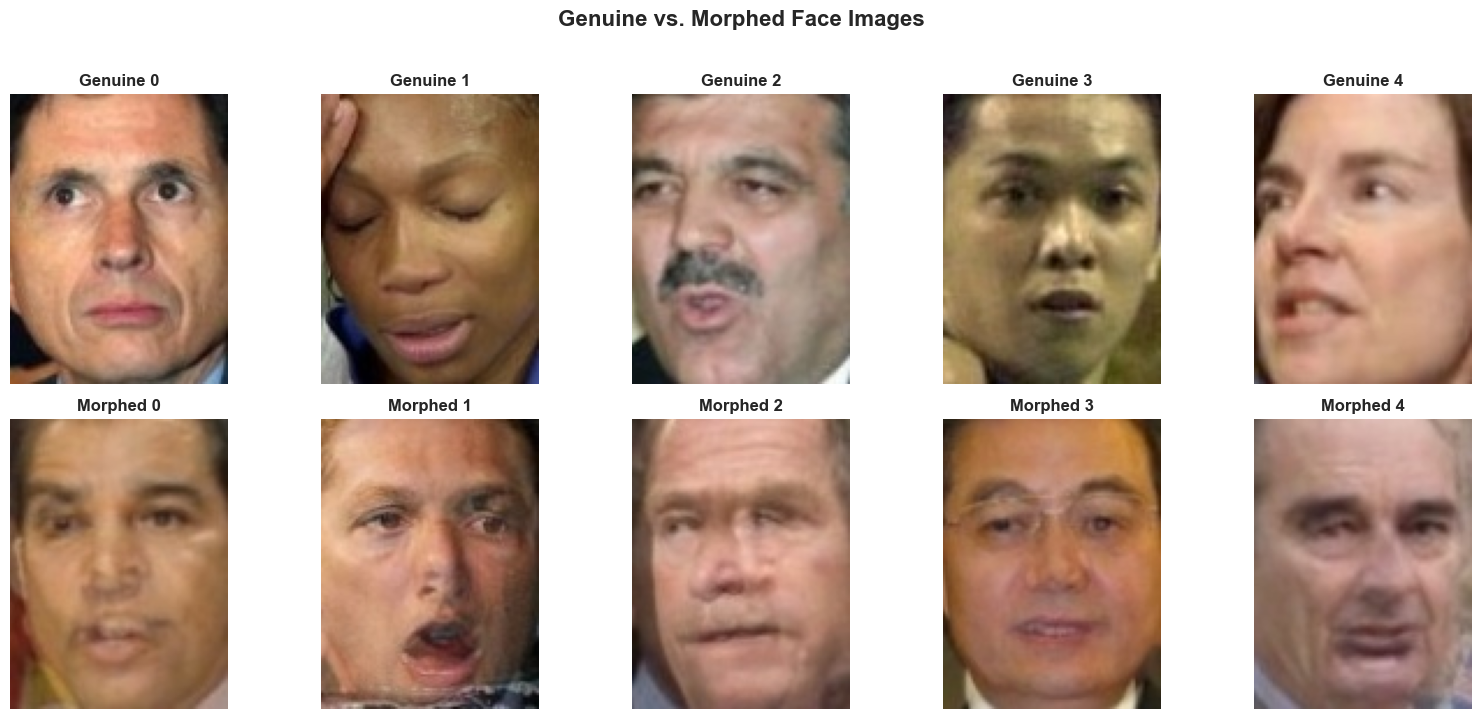


✓ Visualization saved as: morph_examples.png


In [15]:
# Show examples of genuine vs. morphed
fig, axes = plt.subplots(2, 5, figsize=(16, 7))

print("Loading example images...")

# Show genuine images
for i in range(5):
    img_path = Path(f'morph_data/genuine/genuine_{i:04d}.jpg')
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Genuine {i}', fontsize=12, fontweight='bold')
    axes[0, i].axis('off')

# Show morphed images
for i in range(5):
    img_path = Path(f'morph_data/morphed/morph_{i:04d}.jpg')
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Morphed {i}', fontsize=12, fontweight='bold')
    axes[1, i].axis('off')

plt.suptitle('Genuine vs. Morphed Face Images', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('morph_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as: morph_examples.png")

# Create Dataset Class for PyTorch

In [16]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MorphDataset(Dataset):
    """Dataset for genuine vs. morphed face images"""
    
    def __init__(self, morph_dir, genuine_dir, transform=None):
        self.transform = transform
        
        # Get all image paths
        morph_path = Path(morph_dir)
        genuine_path = Path(genuine_dir)
        
        self.morph_images = list(morph_path.glob('*.jpg'))
        self.genuine_images = list(genuine_path.glob('*.jpg'))
        
        # Create labels (0 = genuine, 1 = morphed)
        self.images = self.genuine_images + self.morph_images
        self.labels = [0] * len(self.genuine_images) + [1] * len(self.morph_images)
        
        print(f"Dataset created:")
        print(f"  Genuine: {len(self.genuine_images)}")
        print(f"  Morphed: {len(self.morph_images)}")
        print(f"  Total: {len(self.images)}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Create dataset
dataset = MorphDataset(
    morph_dir='morph_data/morphed',
    genuine_dir='morph_data/genuine',
    transform=transform
)

# Split into train/val/test (60/20/20)
from torch.utils.data import random_split

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"\nData split:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

# Create dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\n✓ Dataloaders ready (batch size: {batch_size})")

Dataset created:
  Genuine: 250
  Morphed: 250
  Total: 500

Data split:
  Train: 300
  Val: 100
  Test: 100

✓ Dataloaders ready (batch size: 32)


# Build Classifier Model

In [17]:
# Use pre-trained ResNet as feature extractor
class MorphDetector(nn.Module):
    def __init__(self):
        super(MorphDetector, self).__init__()
        
        # Load pre-trained ResNet50
        self.resnet = models.resnet50(weights='IMAGENET1K_V1')
        
        # Freeze early layers (we're fine-tuning, not training from scratch)
        for param in list(self.resnet.parameters())[:-20]:
            param.requires_grad = False
        
        # Replace final layer for binary classification
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)  # 2 classes: genuine, morphed
        )
    
    def forward(self, x):
        return self.resnet(x)

# Initialize model
model = MorphDetector().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print("="*80)
print(f"Base: ResNet50 (pre-trained on ImageNet)")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")
print("="*80)
print("\n✓ Model ready for training")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\KaraHoover/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 36.5MB/s]


Model Architecture:
Base: ResNet50 (pre-trained on ImageNet)
Total parameters: 24,558,146
Trainable parameters: 9,975,298
Frozen parameters: 14,582,848

✓ Model ready for training


 # Training Loop

In [18]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(loader)
    val_acc = 100 * correct / total
    
    return val_loss, val_acc

# Training
print("Starting training...")
print("="*80)

num_epochs = 10
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Save metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_morph_detector.pth')
    
    epoch_time = time.time() - start_time
    
    print(f"Epoch {epoch+1}/{num_epochs} ({epoch_time:.1f}s)")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print()

print("="*80)
print(f"✓ Training complete!")
print(f"✓ Best validation accuracy: {best_val_acc:.2f}%")

Starting training...
Epoch 1/10 (4.7s)
  Train Loss: 0.5831 | Train Acc: 68.67%
  Val Loss: 0.5425 | Val Acc: 66.00%

Epoch 2/10 (1.5s)
  Train Loss: 0.2364 | Train Acc: 93.67%
  Val Loss: 0.2100 | Val Acc: 90.00%

Epoch 3/10 (1.5s)
  Train Loss: 0.0520 | Train Acc: 99.67%
  Val Loss: 0.1019 | Val Acc: 95.00%

Epoch 4/10 (1.5s)
  Train Loss: 0.0181 | Train Acc: 100.00%
  Val Loss: 0.0829 | Val Acc: 98.00%

Epoch 5/10 (1.4s)
  Train Loss: 0.0079 | Train Acc: 100.00%
  Val Loss: 0.0720 | Val Acc: 98.00%

Epoch 6/10 (1.4s)
  Train Loss: 0.0031 | Train Acc: 100.00%
  Val Loss: 0.0767 | Val Acc: 98.00%

Epoch 7/10 (1.4s)
  Train Loss: 0.0015 | Train Acc: 100.00%
  Val Loss: 0.0792 | Val Acc: 98.00%

Epoch 8/10 (1.4s)
  Train Loss: 0.0013 | Train Acc: 100.00%
  Val Loss: 0.0813 | Val Acc: 98.00%

Epoch 9/10 (1.4s)
  Train Loss: 0.0009 | Train Acc: 100.00%
  Val Loss: 0.0833 | Val Acc: 98.00%

Epoch 10/10 (1.4s)
  Train Loss: 0.0011 | Train Acc: 100.00%
  Val Loss: 0.0805 | Val Acc: 98.00%

✓

# Evaluation on Test Set

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def evaluate_model(model, loader, device):
    """Get detailed predictions for evaluation"""
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            
            # Get probabilities and predictions
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of "morphed" class
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

print("Evaluating on test set...")
print("="*80)

# Load best model
model.load_state_dict(torch.load('best_morph_detector.pth'))

# Get predictions
test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device)

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print("\nTEST SET PERFORMANCE:")
print("="*80)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}% (of predicted morphs, % actually morphed)")
print(f"Recall: {recall*100:.2f}% (of actual morphs, % detected)")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print("                Predicted")
print("              Genuine  Morphed")
print(f"Actual Genuine    {cm[0,0]:3d}     {cm[0,1]:3d}")
print(f"       Morphed    {cm[1,0]:3d}     {cm[1,1]:3d}")

# False acceptance/rejection rates (biometric terminology)
tn, fp, fn, tp = cm.ravel()
far = fp / (fp + tn)  # False Accept Rate (genuine classified as morphed)
frr = fn / (fn + tp)  # False Reject Rate (morphed classified as genuine)

print(f"\nBiometric Metrics:")
print(f"False Accept Rate (FAR): {far*100:.2f}% (genuine faces flagged as morphed)")
print(f"False Reject Rate (FRR): {frr*100:.2f}% (morphed faces missed)")

# Classification report
print("\n" + "="*80)
print("Detailed Classification Report:")
print("="*80)
print(classification_report(test_labels, test_preds, target_names=['Genuine', 'Morphed']))

print("\n✓ Evaluation complete!")

Evaluating on test set...

TEST SET PERFORMANCE:
Accuracy: 93.00%
Precision: 97.96% (of predicted morphs, % actually morphed)
Recall: 88.89% (of actual morphs, % detected)
F1 Score: 0.9320

Confusion Matrix:
                Predicted
              Genuine  Morphed
Actual Genuine     45       1
       Morphed      6      48

Biometric Metrics:
False Accept Rate (FAR): 2.17% (genuine faces flagged as morphed)
False Reject Rate (FRR): 11.11% (morphed faces missed)

Detailed Classification Report:
              precision    recall  f1-score   support

     Genuine       0.88      0.98      0.93        46
     Morphed       0.98      0.89      0.93        54

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100


✓ Evaluation complete!


# Visualization-Training Curvees

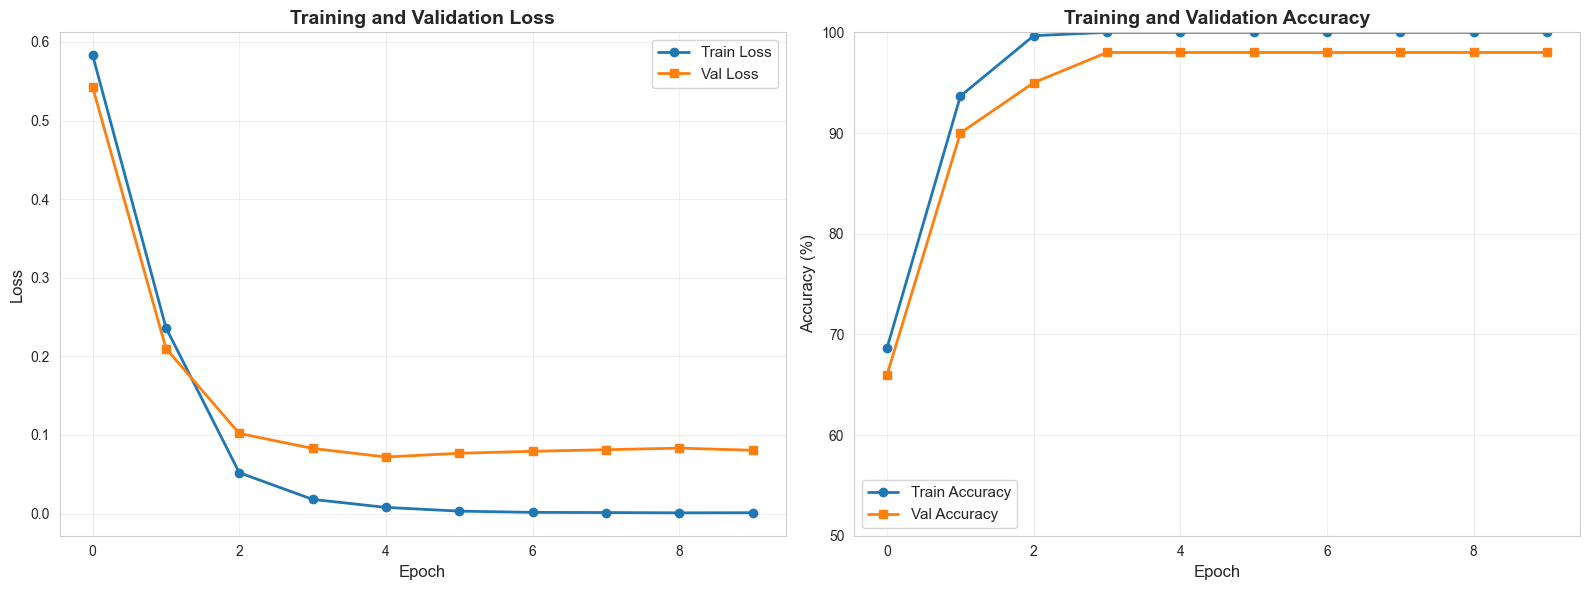

✓ Training curves saved


In [20]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', linewidth=2, marker='o')
axes[0].plot(val_losses, label='Val Loss', linewidth=2, marker='s')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2, marker='o')
axes[1].plot(val_accs, label='Val Accuracy', linewidth=2, marker='s')
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_ylim(50, 100)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved")

# ROC Curves

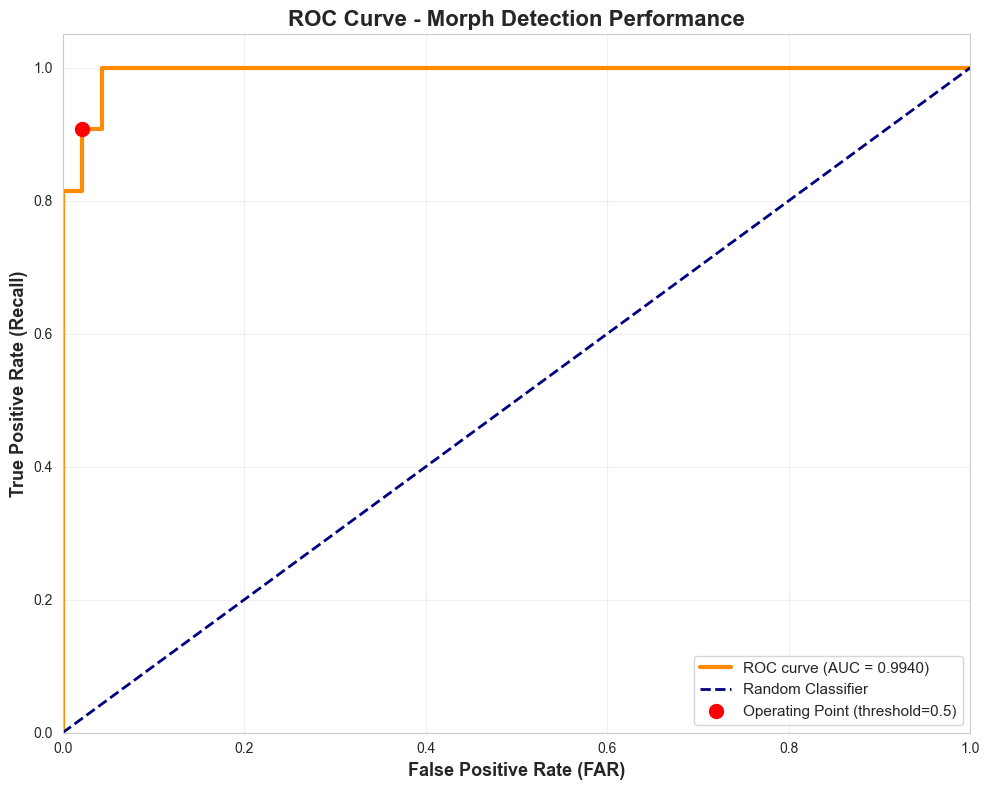

✓ ROC AUC Score: 0.9940
✓ ROC curve saved


In [21]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (FAR)', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate (Recall)', fontsize=13, fontweight='bold')
ax.set_title('ROC Curve - Morph Detection Performance', fontsize=16, fontweight='bold')
ax.legend(loc="lower right", fontsize=12)
ax.grid(alpha=0.3)

# Add operating point at threshold 0.5
idx_05 = np.argmin(np.abs(thresholds - 0.5))
ax.plot(fpr[idx_05], tpr[idx_05], 'ro', markersize=10, label=f'Operating Point (threshold=0.5)')
ax.legend(loc="lower right", fontsize=11)

plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC AUC Score: {roc_auc:.4f}")
print("✓ ROC curve saved")

# Grad-CAM visualization SetUp

In [22]:
import torch.nn.functional as F

class GradCAM:
    """Generate Grad-CAM heatmaps to visualize what the model focuses on"""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class):
        """Generate CAM for target class"""
        # Forward pass
        model_output = self.model(input_image)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass for target class
        target = model_output[0, target_class]
        target.backward()
        
        # Calculate weights
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        
        # Weight activations
        weighted_activations = self.activations * pooled_gradients
        
        # Create heatmap
        heatmap = torch.sum(weighted_activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)  # Only positive contributions
        heatmap = heatmap / torch.max(heatmap)  # Normalize
        
        return heatmap.cpu().numpy()

# Get target layer (last conv layer of ResNet)
target_layer = model.resnet.layer4[-1].conv3

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

print("✓ Grad-CAM ready")

✓ Grad-CAM ready


In [ ]:
# Generate Grad-CAM Visualizations

Generating Grad-CAM visualizations...


c:\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


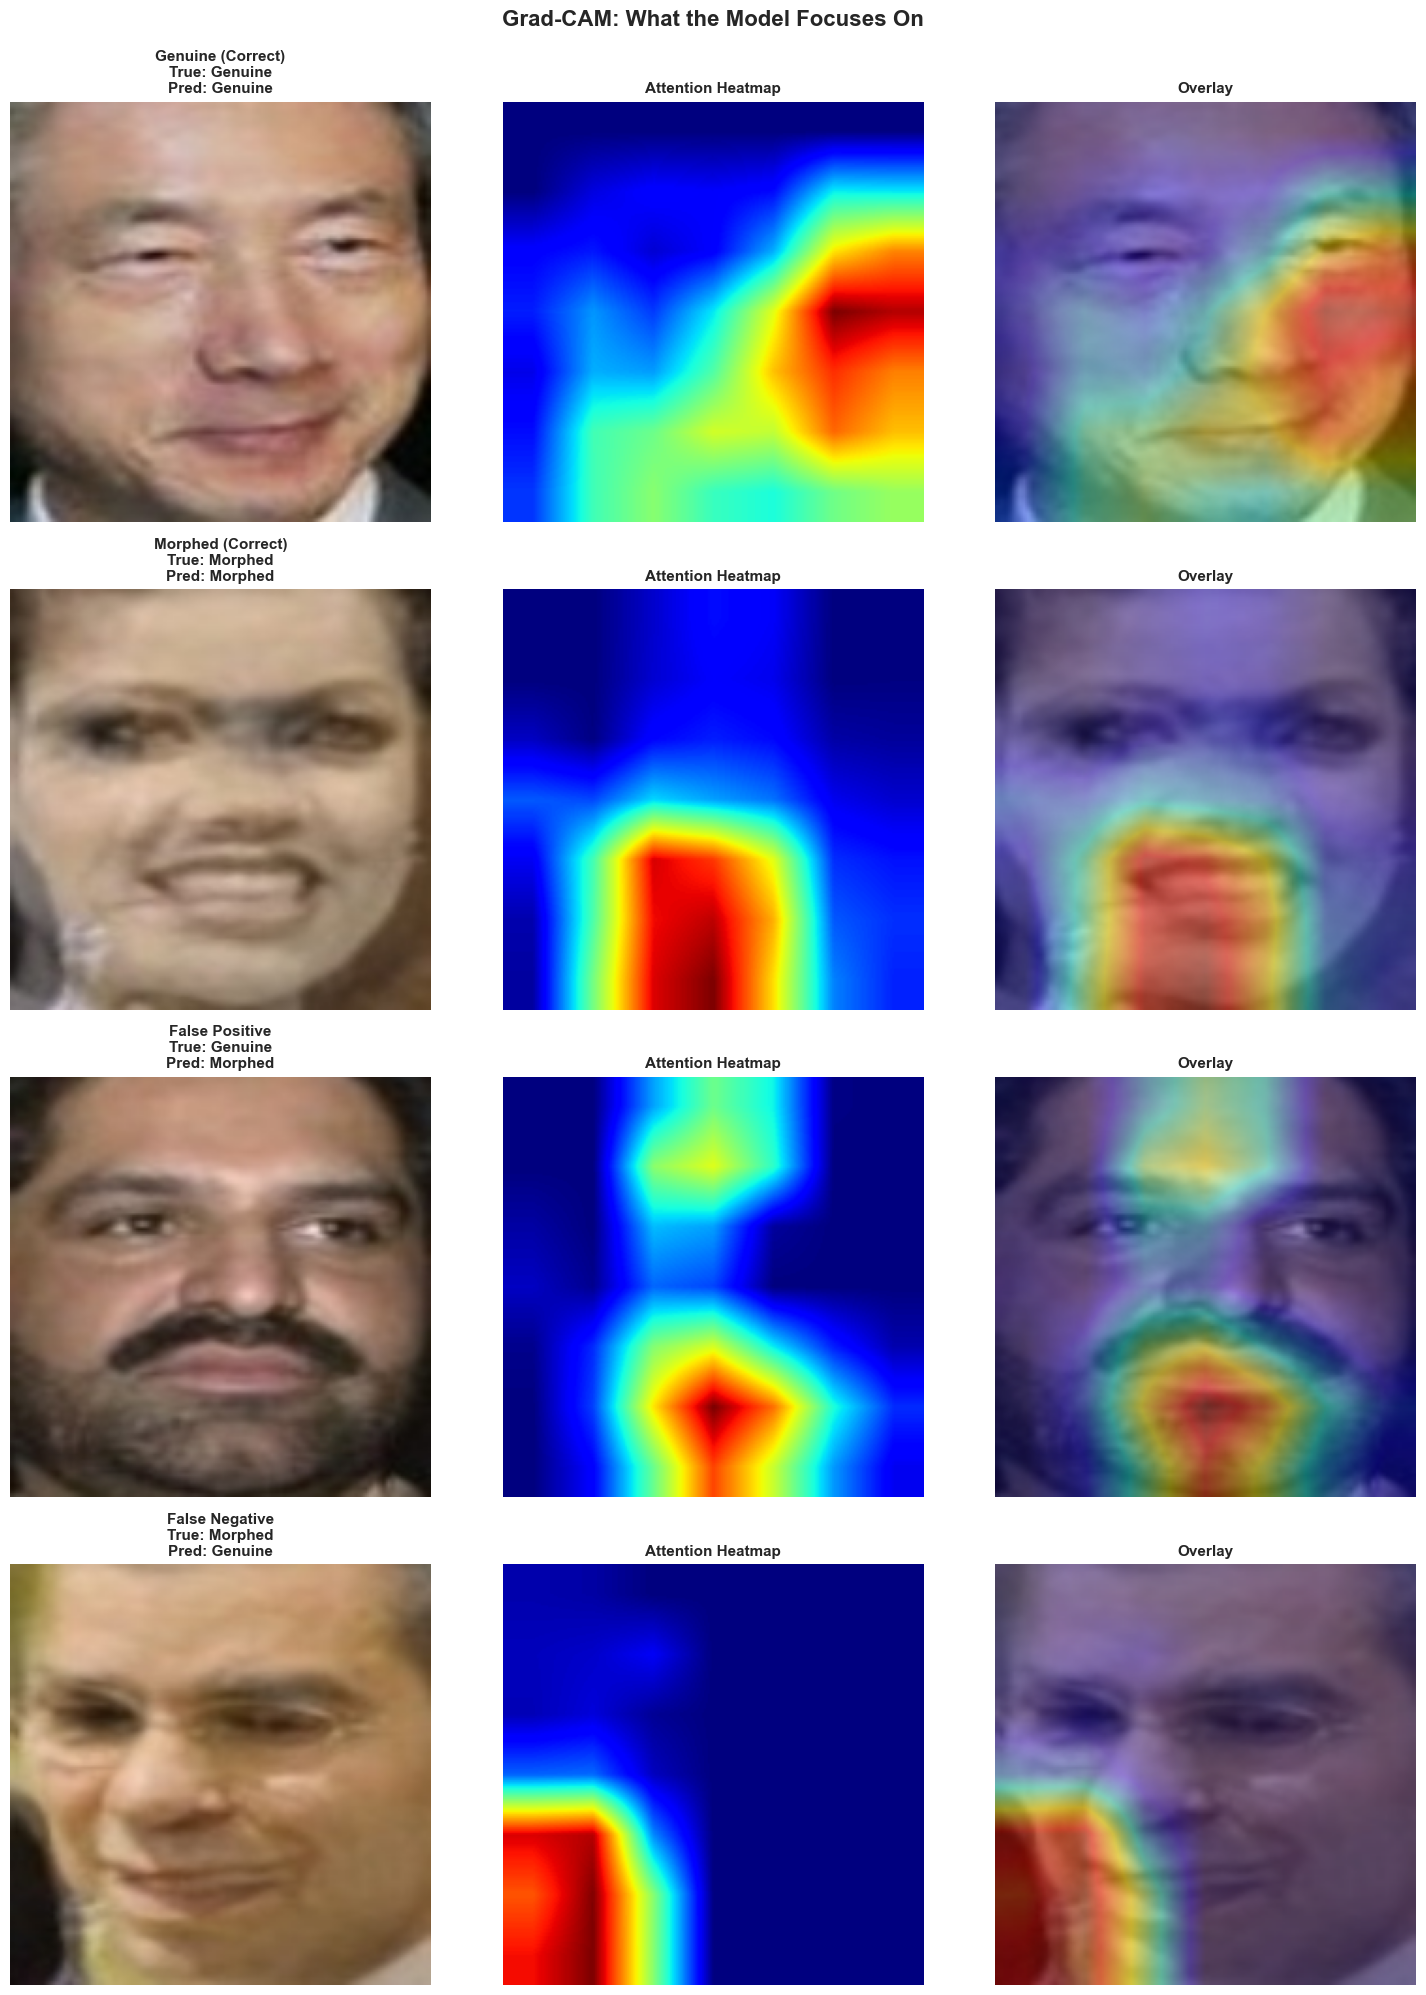


✓ Grad-CAM visualizations saved


In [23]:
def visualize_gradcam(model, image_tensor, original_image, grad_cam, true_label, pred_label):
    """Create Grad-CAM overlay visualization"""
    
    # Generate heatmap
    heatmap = grad_cam.generate_cam(image_tensor.unsqueeze(0).to(device), pred_label)
    
    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    
    # Convert to colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Overlay on original image
    overlay = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)
    
    return heatmap_resized, overlay

# Get some test examples
print("Generating Grad-CAM visualizations...")

# Find examples: correct genuine, correct morphed, false positives, false negatives
genuine_correct = np.where((test_labels == 0) & (test_preds == 0))[0]
morphed_correct = np.where((test_labels == 1) & (test_preds == 1))[0]
false_positives = np.where((test_labels == 0) & (test_preds == 1))[0]
false_negatives = np.where((test_labels == 1) & (test_preds == 0))[0]

# Select examples
examples = []
if len(genuine_correct) > 0:
    examples.append(('Genuine (Correct)', genuine_correct[0]))
if len(morphed_correct) > 0:
    examples.append(('Morphed (Correct)', morphed_correct[0]))
if len(false_positives) > 0:
    examples.append(('False Positive', false_positives[0]))
if len(false_negatives) > 0:
    examples.append(('False Negative', false_negatives[0]))

# Generate visualizations
fig, axes = plt.subplots(len(examples), 3, figsize=(15, 5*len(examples)))
if len(examples) == 1:
    axes = axes.reshape(1, -1)

for row, (label, idx) in enumerate(examples):
    # Get image from test set
    # Reconstruct which image this is
    test_idx_counter = 0
    for i, (img, lbl) in enumerate(test_dataset):
        if test_idx_counter == idx:
            image_tensor = img
            true_label = lbl
            break
        test_idx_counter += 1
    
    # Denormalize for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_denorm = image_tensor * std + mean
    img_denorm = torch.clamp(img_denorm, 0, 1)
    original_image = (img_denorm.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    
    pred_label = test_preds[idx]
    
    # Generate Grad-CAM
    heatmap, overlay = visualize_gradcam(
        model, image_tensor, original_image, grad_cam, 
        true_label, pred_label
    )
    
    # Plot
    axes[row, 0].imshow(original_image)
    axes[row, 0].set_title(f'{label}\nTrue: {"Morphed" if true_label==1 else "Genuine"}\nPred: {"Morphed" if pred_label==1 else "Genuine"}', 
                          fontsize=11, fontweight='bold')
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(heatmap, cmap='jet')
    axes[row, 1].set_title('Attention Heatmap', fontsize=11, fontweight='bold')
    axes[row, 1].axis('off')
    
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title('Overlay', fontsize=11, fontweight='bold')
    axes[row, 2].axis('off')

plt.suptitle('Grad-CAM: What the Model Focuses On', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('gradcam_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Grad-CAM visualizations saved")

# Create Summary Report

_IncompleteInputError: incomplete input (3951284126.py, line 1)